# Setup

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn')

<ipython-input-1-837f75639780>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Utility

In [2]:
# Create sequences for training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Data

## Data Fetching and loading

In [4]:
# Define the date range
start_date = '2018-01-01'
end_date = '2023-08-01'

# Fetch Bitcoin data from Yahoo Finance
data = yf.download('BNB-USD', start=start_date, end=end_date)

# Extract the 'Close' prices and the corresponding dates
close_prices = data['Close'].values
dates = data.index

[*********************100%%**********************]  1 of 1 completed


## Data Exploration

In [5]:
data.shape

(2038, 6)

In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,8.62953,8.700570,7.95922,8.41461,8.41461,66422800
2018-01-02,8.45770,9.122590,8.21718,8.83777,8.83777,104789000
2018-01-03,8.77014,9.580780,8.52918,9.53588,9.53588,108852000
2018-01-04,9.44584,9.538490,8.85413,9.21399,9.21399,158819008
2018-01-05,9.14568,16.717699,9.09468,14.91720,14.91720,341504992


In [7]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-27,238.960114,243.163513,238.638443,240.498795,240.498795,433186880
2023-07-28,240.505127,242.796997,239.987869,241.977036,241.977036,388148322
2023-07-29,241.971344,242.726273,241.323135,242.576370,242.576370,317500344
2023-07-30,242.582214,243.785721,240.925186,242.525986,242.525986,425584373
2023-07-31,242.519592,244.202576,240.764450,241.120651,241.120651,1092564922


In [8]:
data.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

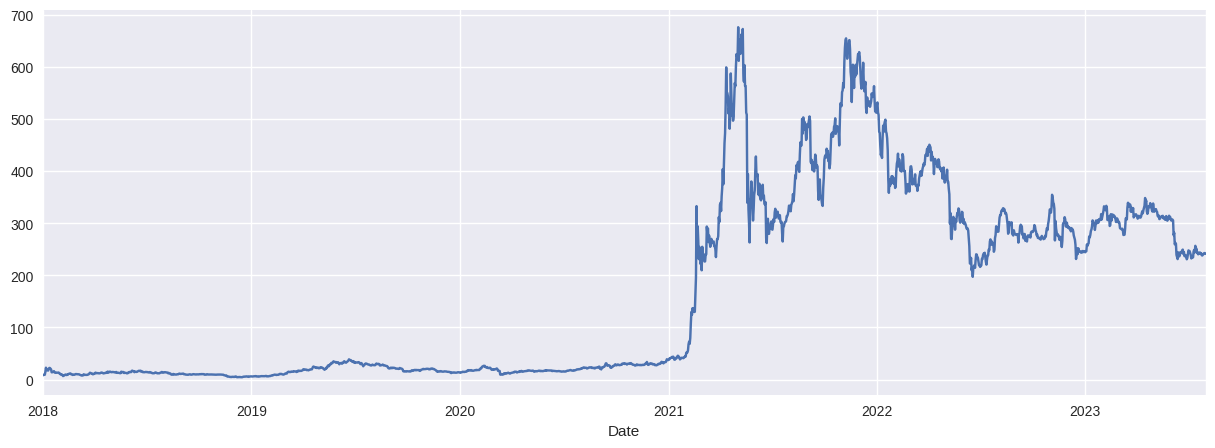

In [9]:
data['Close'].plot(figsize=(15, 5));

## Data spliting

In [10]:
# Split data into training (80%) and testing (20%) sets
train_size = int(len(close_prices) * 0.8)
test_size = len(close_prices) - train_size
train_data, test_data = close_prices[0:train_size], close_prices[train_size:]
train_dates, test_dates = dates[:train_size], dates[train_size:]

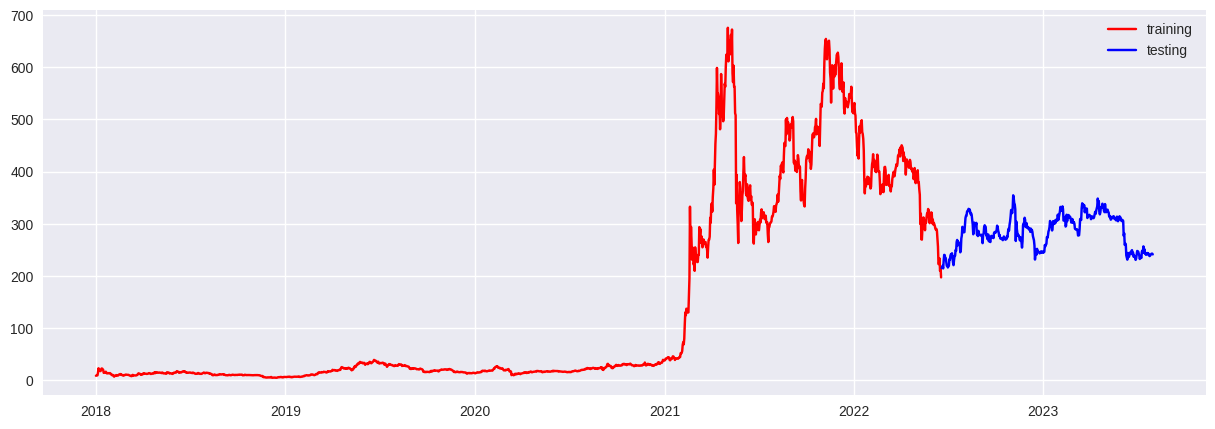

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(train_dates, train_data, label='training', color='red')
plt.plot(test_dates, test_data, label='testing', color='blue')
plt.legend();

## Data Preprocessing

In [12]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))

In [13]:
seq_length = 10  # Adjust the sequence length as needed
X_train = create_sequences(train_data, seq_length)
y_train = train_data[seq_length:]
X_test = create_sequences(test_data, seq_length)
y_test = test_data[seq_length:]

# Model

In [14]:
# Build an LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_length, 1), return_sequences=True))
model.add(LSTM(80, return_sequences=True))
model.add(LSTM(80, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# Train the model
r = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=530,
    batch_size=64
)

Epoch 1/530
26/26 [==============================] - 14s 95ms/step - loss: 0.0375 - val_loss: 0.0039
Epoch 2/530
26/26 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 9.5063e-04
Epoch 3/530
26/26 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 9.4611e-04
Epoch 4/530
26/26 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 5/530
26/26 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/530
26/26 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/530
26/26 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 8/530
26/26 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 9/530
26/26 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 10/530
26/26 [==============================] - 0s 11ms/step - loss: 0.0023 - val_los

## Model Evaluation

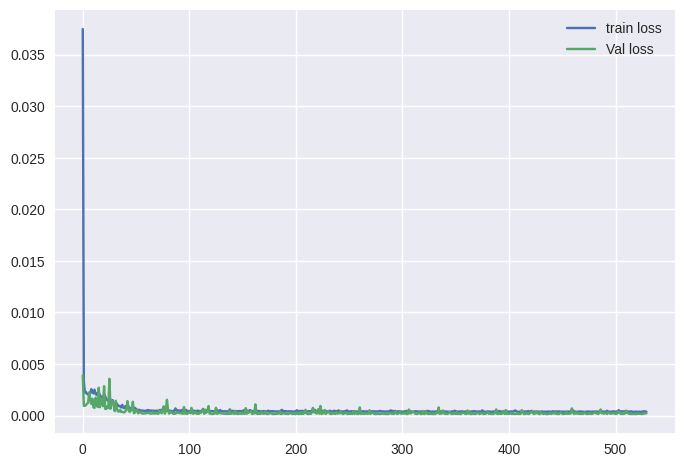

In [15]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='Val loss')
plt.legend();

In [16]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Inverse transform the scaled predictions and original values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

13/13 [==============================] - 2s 6ms/step


In [17]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, predictions)

print(f'RMSE: {rmse:.2f}')
print(f'MAPE: {mape:.2f}%')

RMSE: 9.91
MAPE: 2.75%


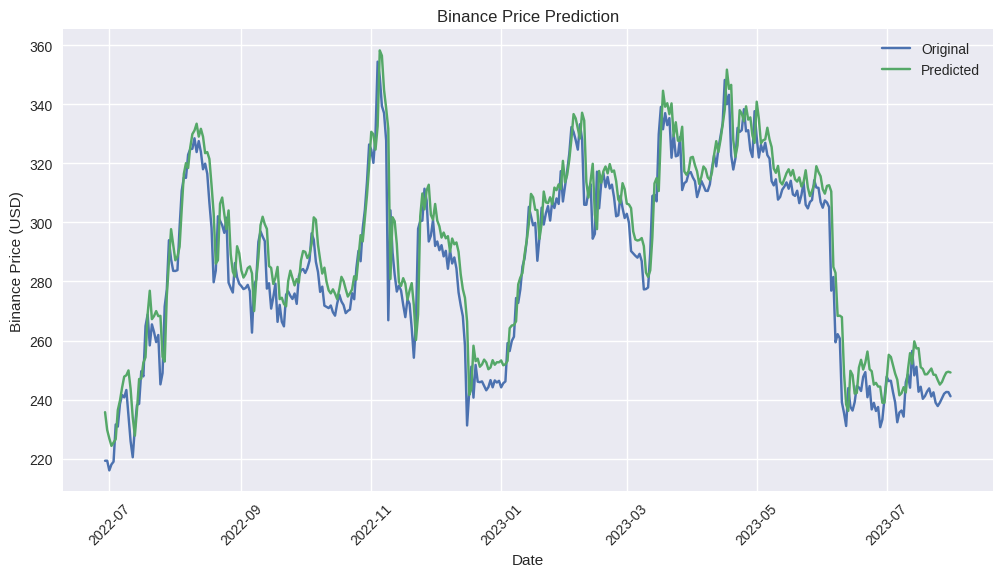

In [18]:
# Plot the predicted vs. original values with dates
plt.figure(figsize=(12, 6))
plt.plot(test_dates[seq_length:], y_test, label='Original')
plt.plot(test_dates[seq_length:], predictions, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Binance Price (USD)')
plt.legend()
plt.title('Binance Price Prediction')
plt.xticks(rotation=45)
plt.show()